In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

/home/fm-pc-lt-238/miniconda3/envs/demand/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Dataset

In [2]:
file_path = "daily_sales_summary.xlsx"

In [3]:
df = pd.read_excel(file_path, sheet_name=0)
df.head()

,Date Range,sales,Units Sold,promotions_on,promotions_off
0,2025-09-09,12612.13,23,15,8
1,2025-09-10,8956.10,16,11,5
2,2025-09-11,10656.95,18,13,5
3,2025-09-12,12639.72,28,21,7
4,2025-09-13,5098.64,7,4,3


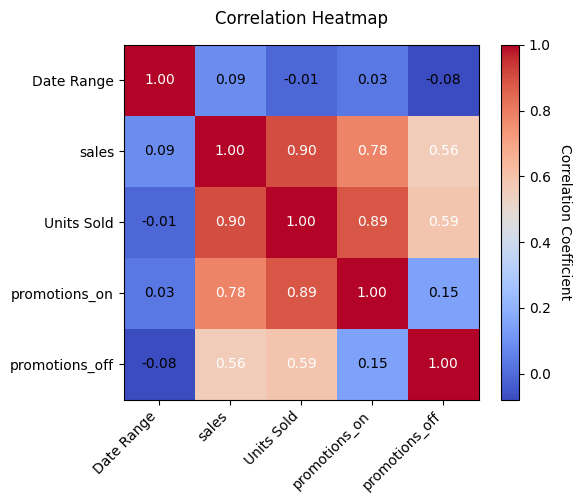

In [4]:
corr = df.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap='coolwarm', interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15)

# Set ticks and labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# Annotate correlation values
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha='center', va='center',
                color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

ax.set_title('Correlation Heatmap', pad=15)
plt.tight_layout()
plt.show()

## Data cleaning and preprocessing
Prophet needs columns:
- ds → date column
- y → target column (here “Units Sold”)

In [5]:
# Clean column names
df.columns = df.columns.str.strip()

# Convert 'Date Range' to datetime
df['Date Range'] = pd.to_datetime(df['Date Range'])

# Select only needed columns for Prophet
df_prophet = df[['Date Range', 'Units Sold', 'promotions_on', 'promotions_off']].rename(columns={'Date Range': 'ds', 'Units Sold': 'y'})


In [6]:
df_prophet.head()

,ds,y,promotions_on,promotions_off
0,2025-09-09,23,15,8
1,2025-09-10,16,11,5
2,2025-09-11,18,13,5
3,2025-09-12,28,21,7
4,2025-09-13,7,4,3


## Visualize the time series

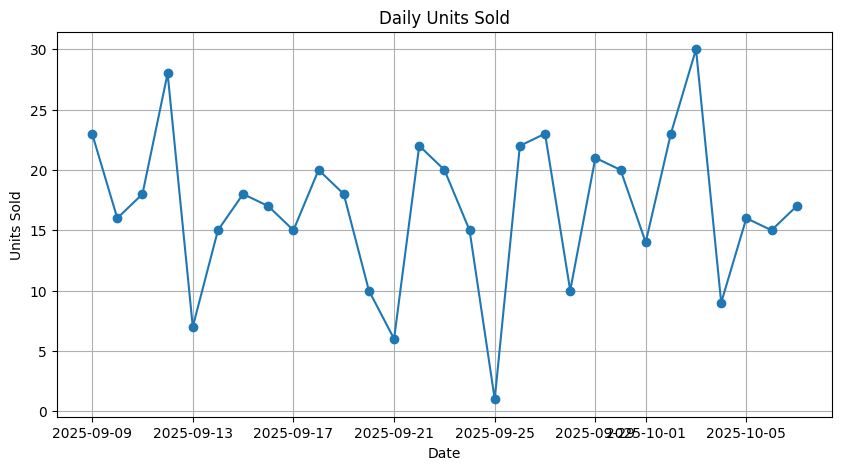

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df_prophet['ds'], df_prophet['y'], marker='o')
plt.title("Daily Units Sold")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_prophet['ds'], df_prophet['Customer Visits'], marker='o')
plt.title("Daily Customer Visits")
plt.xlabel("Date")
plt.ylabel("Customer Visits")
plt.grid(True)
plt.show()

## Fit Prophet model

In [8]:
# Initialize and fit prophet
model = Prophet()
model.add_seasonality(name="weekly", period=7, fourier_order=2)
model.fit(df_prophet)

20:14:51 - cmdstanpy - INFO - Chain [1] start processing
20:14:51 - cmdstanpy - INFO - Chain [1] done processing


## Make future predictions

In [9]:
# Create future dataframe
future = model.make_future_dataframe(periods=15)  # 15 days ahead

# Predict
forecast = model.predict(future)

# View results
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)


,ds,yhat,yhat_lower,yhat_upper
29,2025-10-08,13.288166,6.427006,20.272303
30,2025-10-09,17.440401,10.977155,23.829876
31,2025-10-10,22.182037,15.936854,28.475456
32,2025-10-11,13.964851,7.510334,20.674059
33,2025-10-12,10.429987,4.008273,16.770667
34,2025-10-13,19.105662,12.842322,25.266330
35,2025-10-14,19.825709,13.823575,25.911440
36,2025-10-15,13.234850,7.092773,19.777756
37,2025-10-16,17.387085,11.198538,23.404465
38,2025-10-17,22.128721,15.855842,28.719795


## Visualize the forecast

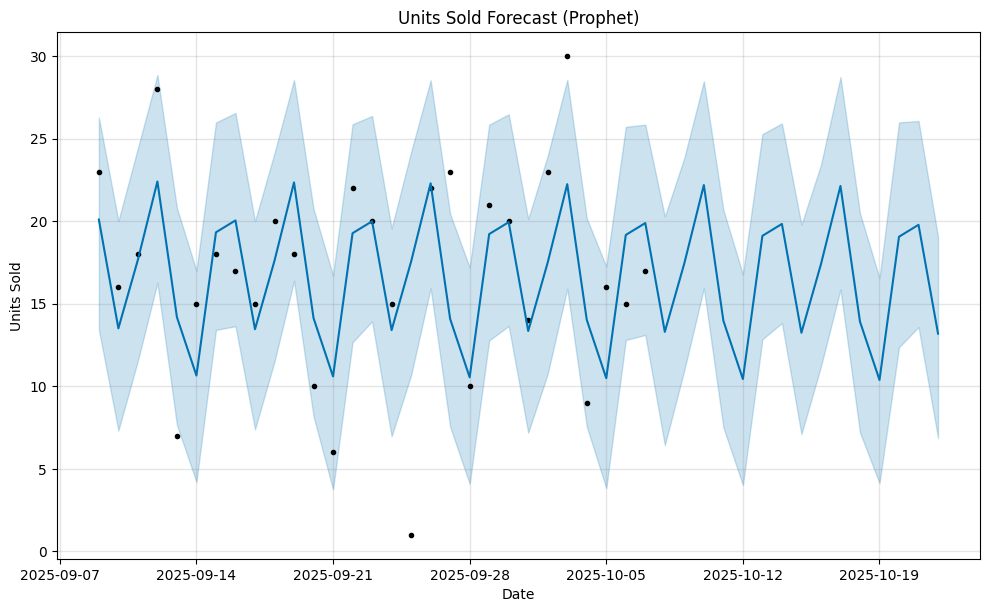

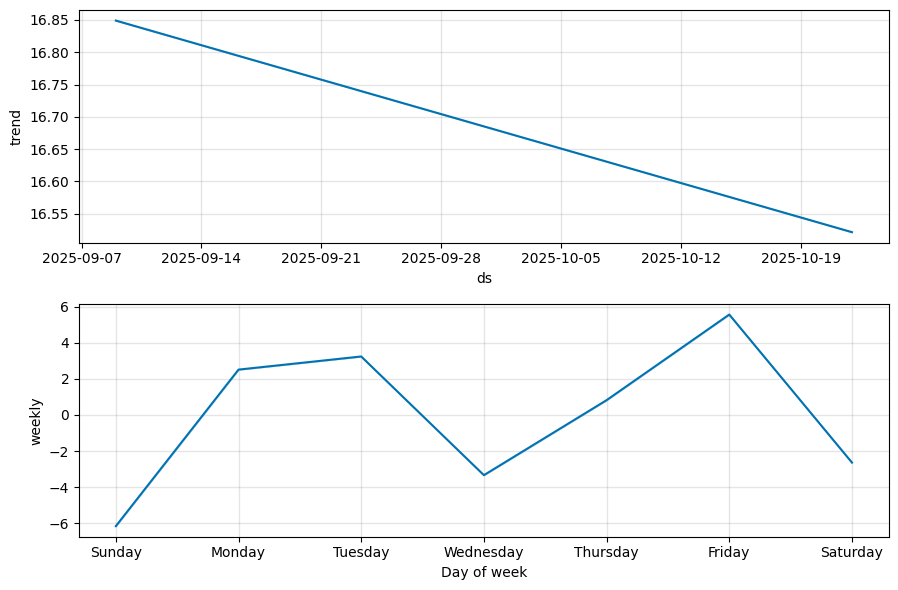

In [10]:
# Plot forecast
model.plot(forecast)
plt.title("Units Sold Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

# Plot trend and seasonality components
model.plot_components(forecast)
plt.show()


## Split data

In [11]:
df_prophet = df[['Date Range', 'Units Sold', "promotions_on", "promotions_off"]].rename(columns={'Date Range': 'ds', 'Units Sold': 'y'})

# Split dataset
train = df_prophet.iloc[:25]  # first 25 days
test = df_prophet.iloc[25:]   # last 5 days

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (25, 4)
Test shape: (4, 4)


## Fit Prophet on training set

In [12]:
# Initialize and fit model on training data
model = Prophet() # default seasonality of fourier_order=3
model.add_seasonality(name="weekly", period=7, fourier_order=2)
model.fit(train)


model_extra_feat = Prophet() # default seasonality of fourier_order=3
model_extra_feat.add_seasonality(name="weekly", period=7, fourier_order=2)
model_extra_feat.add_regressor('promotions_on')
model_extra_feat.add_regressor('promotions_off')
model_extra_feat.fit(train)

# model_with_seasonality = Prophet()
# model_with_seasonality.add_seasonality(name="weekly", period=7, fourier_order=2)
# model_with_seasonality.fit(train)

# model_extra_feat = Prophet() # default seasonality of fourier_order=3
# model_extra_feat.add_regressor('Customer Visits')
# model_extra_feat.fit(train)

20:15:02 - cmdstanpy - INFO - Chain [1] start processing


20:15:02 - cmdstanpy - INFO - Chain [1] done processing
20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:04 - cmdstanpy - INFO - Chain [1] done processing


## Create future dataframe for test period

In [14]:
# Forecast for the test period (next 5 days)
future_test = model.make_future_dataframe(periods=len(test), freq='D')
forecast_test = model.predict(future_test)

# Keep only test period predictions
predictions = forecast_test[['ds', 'yhat']].iloc[-len(test):]
predictions.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Combine actual vs predicted
results = test.copy()
results['yhat'] = predictions['yhat']

###################### model with custom seasonality ###########################
# future_test = model_with_seasonality.make_future_dataframe(periods=len(test), freq='D')
# forecast_test_seasonality = model_with_seasonality.predict(future_test)

# # Keep only test period predictions
# predictions = forecast_test_seasonality[['ds', 'yhat']].iloc[-len(test):]
# predictions.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

# # Combine actual vs predicted
# # results = test.copy()
# results['yhat_seasonality'] = predictions['yhat']

###################### model with extra features ###########################
future_test = model_extra_feat.make_future_dataframe(periods=len(test), freq='D')[-len(test):]
future_test.reset_index(drop=True, inplace=True)
future_test["promotions_on"] = test["promotions_on"]
future_test["promotions_off"] = test["promotions_off"]
forecast_extra_feat = model_extra_feat.predict(future_test)

# Keep only test period predictions
predictions = forecast_extra_feat[['ds', 'yhat']].iloc[-len(test):]
predictions.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Combine actual vs predicted
# results = test.copy()
results['yhat_promotions'] = predictions['yhat']

print(results)

          ds   y  promotions_on  promotions_off       yhat  yhat_promotions
0 2025-10-04   9              6               3  15.546804         9.062563
1 2025-10-05  16             14               2  11.048535        16.208777
2 2025-10-06  15              5              10  20.661657        15.177332
3 2025-10-07  17             15               2  22.396724        17.159610


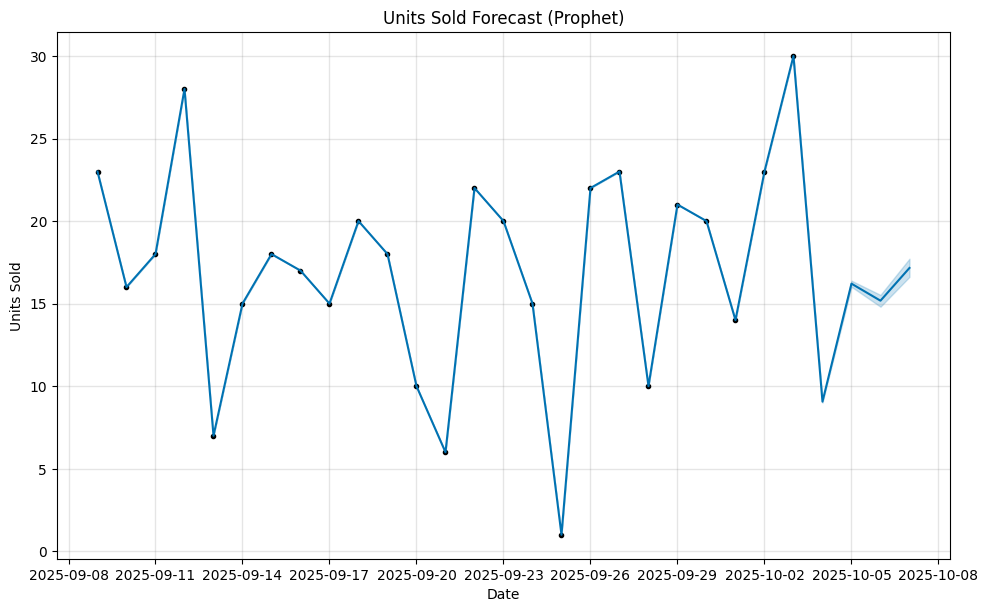

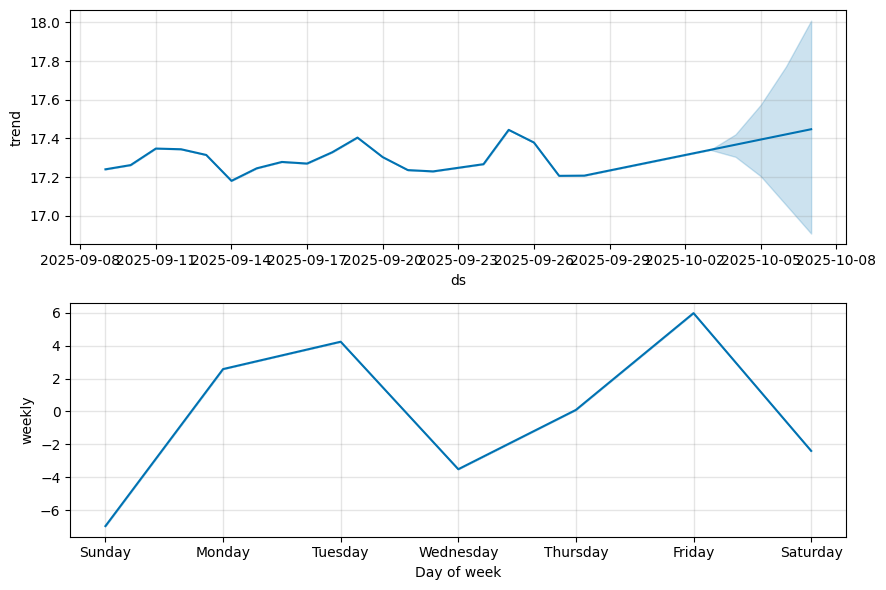

In [18]:
future_test = model_extra_feat.make_future_dataframe(periods=len(test), freq='D')
future_test["promotions_on"] = df_prophet["promotions_on"]
future_test["promotions_off"] = df_prophet["promotions_off"]
forecast_extra_feat = model_extra_feat.predict(future_test)

# Plot forecast
model_extra_feat.plot(forecast_extra_feat)
plt.title("Units Sold Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

# Plot trend and seasonality components
model.plot_components(forecast_extra_feat)
plt.show()

## Calculate metrics: MAE, RMSE, RMSLE

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual and predicted values
y_true = results['y']
y_pred = results['yhat']

# y_pred_seasonality = results['yhat_seasonality']
y_pred_promotions = results['yhat_promotions']


# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Metrics Seasonality
# mae_seasonality = mean_absolute_error(y_true, y_pred_seasonality)
# rmse_seasonality = mean_squared_error(y_true, y_pred_seasonality)
# rmsle_seasonality = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred_seasonality)))

# Metrics Extra Feature
mae_extra_feat = mean_absolute_error(y_true, y_pred_promotions)
rmse_extra_feat = mean_squared_error(y_true, y_pred_promotions)
rmsle_extra_feat = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred_promotions)))

# metrics_df = pd.DataFrame({
#     'MAE': [mae, mae_seasonality, mae_extra_feat],
#     'RMSE': [rmse, rmse_seasonality, rmse_extra_feat],
#     'RMSLE': [rmsle, rmsle_seasonality, rmsle_extra_feat]
# }, index=['Default', 'Seasonality', 'Extra_Feature'])

metrics_df = pd.DataFrame({
    'MAE': [mae,  mae_extra_feat],
    'RMSE': [rmse,  rmse_extra_feat],
    'RMSLE': [rmsle,  rmsle_extra_feat]
}, index=['Default', 'Promotions'])

metrics_df

# print(f"MAE: {mae:.2f}")
# print(f"RMSE: {rmse:.2f}")
# print(f"RMSLE: {rmsle:.4f}")

# print(f"MAE Seasonality: {mae_seasonality:.2f}")
# print(f"RMSE Seasonality: {rmse_seasonality:.2f}")
# print(f"RMSLE Seasonality: {rmsle_seasonality:.4f}")


,MAE,RMSE,RMSLE
Default,5.639163,32.139161,0.364927
Promotions,0.152070,0.026106,0.009840


## Plot actual vs predicted

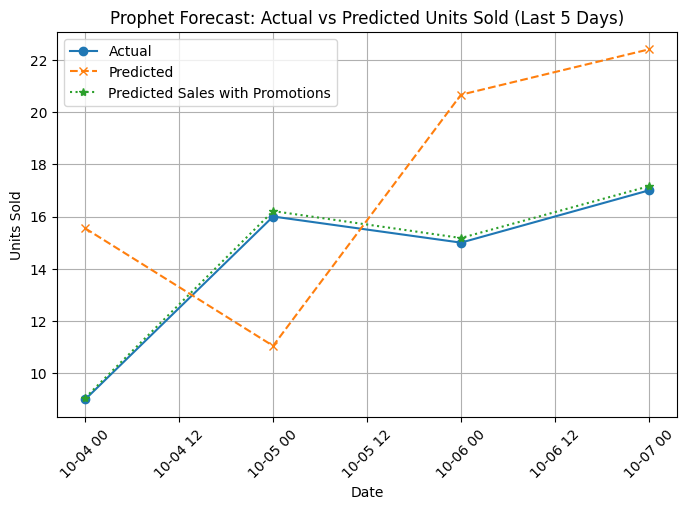

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(results['ds'], results['y'], marker='o', label='Actual')
plt.plot(results['ds'], results['yhat'], marker='x', linestyle='--', label='Predicted')
# plt.plot(results['ds'], results['yhat_seasonality'], marker='s', linestyle='-.', label='Predicted Seasonality')
plt.plot(results['ds'], results['yhat_promotions'], marker='*', linestyle=':', label='Predicted Sales with Promotions')

plt.title("Prophet Forecast: Actual vs Predicted Units Sold (Last 5 Days)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()